LSTM method using this method as a source https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

tldr: Transform dataset into supervised method, make it stationary, transform to scale, LSTM

In [51]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, tnrange
import os

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [23]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit a network to training data
def fit_seq(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    #X = X.reshape(X.shape[0], 1, X.shape[1])
    
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_dim=X.shape[1]))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
    return model

# make a one-step forecast
def forecast_seq(model, batch_size, X):
    X = X.reshape(1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0, 0]

Alternative prediction using the last predicted value as the input. This is necessary because we want to predict more than one time unit ahead.

In [24]:
def scale2(train_data):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_data)
    # transform train
    train = train_data.reshape(train_data.shape[0], train_data.shape[1])
    train_scaled = scaler.transform(train_data)
    return scaler, train_scaled

def make_predictions(model, train_scaled, scaler, raw_values, number_of_predictions):
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1)
    model.predict(train_reshaped, batch_size=1)

    scaled_predictions = list()
    predictions = list()
    X = train_scaled[-1,1:2]

    yhat = forecast_seq(model, 1, X)
    scaled_predictions.append(yhat)
    
    yhat = invert_scale(scaler, X, yhat)
    yhat = yhat + raw_values[-1]
    predictions.append(yhat)
    
    # Predict N steps into the FUTURE!
    for i in range(1, number_of_predictions):
        X = np.array([scaled_predictions[-1]])
        yhat = forecast_seq(model, 1, X)
        scaled_predictions.append(yhat)
        
        yhat = invert_scale(scaler, X, yhat)
        yhat = yhat + predictions[-1]
        predictions.append(yhat)
    
    # removed for mass predictions
    #print(scaled_predictions)
    #print(predictions)
    return predictions
    

def create_model_and_predict(train_series, number_of_predictions):
    # transform data to be stationary
    raw_values = train_series.values
    diff_values = difference(raw_values, 1)

    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values

    # transform the scale of the data
    scaler, train_scaled = scale2(supervised_values)

    # fit the model
    model = fit_seq(train_scaled, 4, 10, 4)
    
    predictions = make_predictions(model, train_scaled, scaler, raw_values, number_of_predictions)
    return predictions

Failsafe single prediction

Loopy predictions

In [58]:
# Prediction lengths for different scopes
horizon_lengths = {"H" : 48, "D" : 14, "M" : 18, "Q" : 8, "Y" : 6}

# All filenames for different scopes
#filenames = os.listdir("./data/cut/1000/train/")
filenames = ["Hourly.csv", "Daily.csv"]

# Results
results_frame = pd.DataFrame()

# Test series frame for plotting or w/e
test_frame = pd.DataFrame()

for file in filenames:
    train_set = pd.read_csv('./data/cut/1000/train/' + file)
    test_set = pd.read_csv('./data/cut/1000/test/' + file)
    
    # Go through all the time series in the scope 
    for i in tnrange(1, train_set.shape[0], desc=file):
        series_name = train_set.iloc[i, 1]
        n_predictons = horizon_lengths[series_name[0].upper()]
        
        series = train_set.iloc[i, 2:].dropna()
        test_series = test_set.iloc[i, 1:].tolist()
        test_series.insert(0, series_name)
        
        pred = create_model_and_predict(series, n_predictons)
        pred.insert(0, series_name)
        
        # Square brackets append the list as a row
        results_frame = results_frame.append([pred], ignore_index=True)
        test_frame = test_frame.append([test_series], ignore_index=True)   
        #assert False
    #assert False

C:\Users\Martin\Anaconda3\lib\site-packages\pandas\core\frame.py:5186: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  other = other.loc[:, self.columns]
C:\Users\Martin\Anaconda3\lib\site-packages\pandas\core\indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


KeyboardInterrupt: 

Write the resulting data frame to .csv

In [34]:
results_frame.to_csv("./d_h_results_seq.csv", index=False)

Printing out a single prediction, if one so chooses

Test RMSE: 191.892


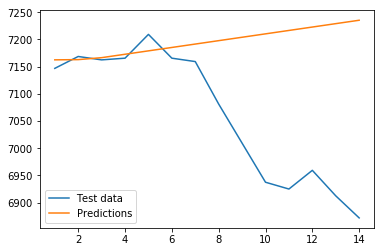

In [35]:
rmse = np.sqrt(mean_squared_error(test_frame.iloc[0, 1:], results_frame.iloc[0, 1:]))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(test_frame.iloc[0, 1:], label="Test data")
plt.plot(results_frame.iloc[0, 1:], label="Predictions")
plt.legend()
plt.show()